### Random Forest


#### 1.bagging 和 pasting 
- bagging: 在不同的训练集随机子集上进行训练，采样时将样本放回 
- pasting: 在不同的训练集随机子集上进行训练，采样时样本不妨会

#### 2.随机森林

通过构建大量决策树来进行分类或回归任务，并通过聚合这些树的预测结果来提高整体模型的准确性和鲁棒性。随机森林的"随机"体现在两个关键方面：一是在每棵树的训练过程中，从原始训练数据集中随机选择一部分数据点，即通过自助采样（bootstrap sampling）形成不同的数据子集；二是在每棵树的每个分裂节点上，并不是考虑所有可能的特征，而是随机选择一部分特征进行最佳分裂点的搜索



![random forest.png](<attachment:random forest.png>)
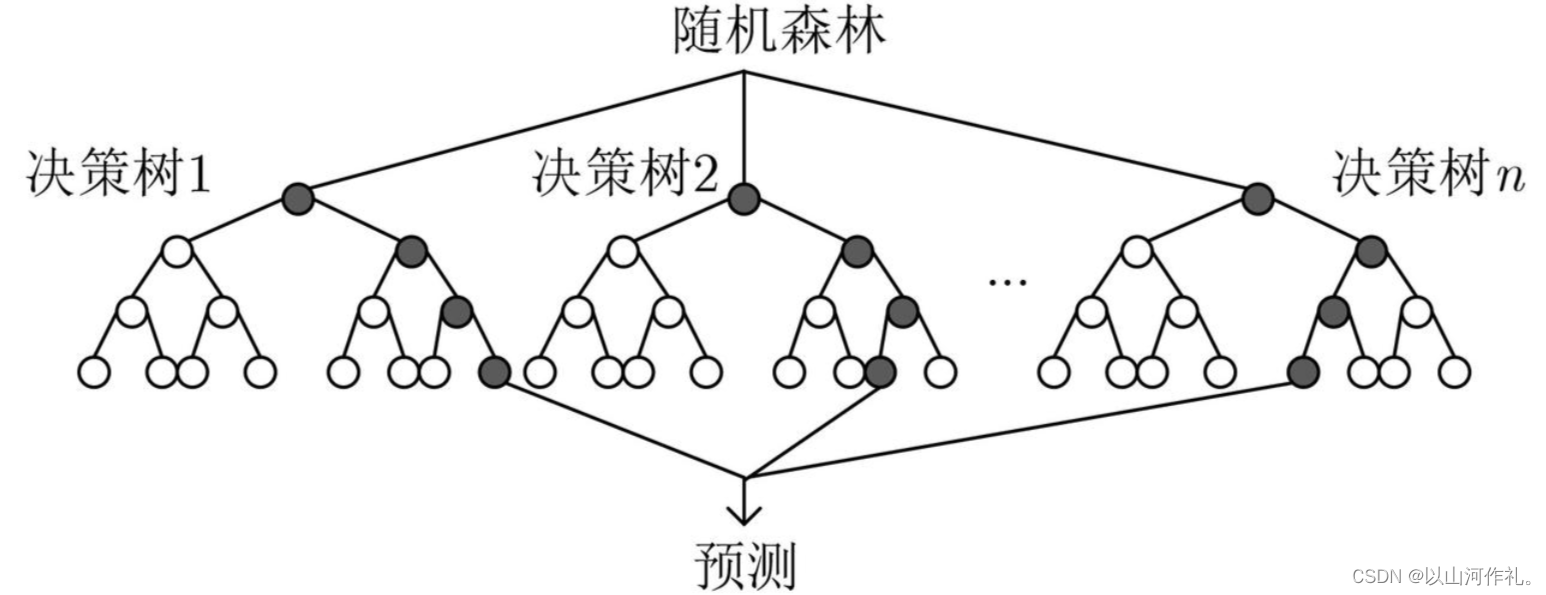

- 数据预处理：对原始数据进行清洗和标准化，以确保算法的有效运行。
- 自助采样：从原始数据集中通过自助采样的方式抽取多个不同的训练数据集。自助采样允许数据集中的样本重复出现，这意味着每个训练集的大小与原始数据集相同，但包含一些重复的样本。
- 特征随机选择：在每棵树的每个分裂节点上，随机选择一部分特征，而不是考虑所有可能的特征。这一步进一步增加了模型的多样性，并有助于减少过拟合。
- 决策树构建：使用每个训练数据集构建决策树，直到每个树达到其最大深度或达到其他停止条件。
- 预测和聚合：对于分类问题，每棵树给出一个预测，最终的预测结果是所有树预测结果的多数投票；对于回归问题，则是所有树预测结果的平均值。

##### 超参数包括  
1. 关于森林的超参数：n_estimators，bootstrap，max_samples，max_features，oob_score
其中n_estimators是最重要的超参数，max_samples一般取原始数据集的数据量（但样本量太大时，也可以稍微调小），max_features一般可以先取log或者sqrt来观察特征数量是较多还是较少比较合适。
2. 分裂准则：criterion："squared_error", "absolute_error", "friedman_mse", "poisson"
RMSE是比较常用的准则，MAE进行优化的时候需要计算中位数，计算复杂度较高，possion损失在标签近似服从泊松分布时比较有效，即单位时间内发生的次数这种类型
3. 关于树本身的超参数：max_depth,min_samples_split,min_weight_fraction_leaf,min_samples_leaf,max_leaf_nodes,min_impurity_decrease;ccp_alphaz


In [1]:
import pandas as pd 
import numpy as np 
import jieba 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False   
from gensim.models import Word2Vec

In [2]:
df = pd.read_csv(
    r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\comments_data.csv',
    encoding='gbk'
)
print(df.head())
print(f'评论总数量：{len(df["comments"])}')

                                            comments  sentiment
0  买来用做PS和Pr等，性能非常强大，外观非常好看，很轻很薄，界面颜色很好看，很流畅，视网膜屏...          0
1  按事情音质非常不错！屏幕分辨率焕然一新！第一次入手苹果生态！感觉好极了。键盘也很耐用爱了爱了...          0
2  性能非常强大，外观非常好看，很轻很薄，界面颜色很好看，很流畅，可以做多用途，京东自营肯定有正...          0
3  运行速度：非常快，屏幕效果：显示很细腻很爽啊！，散热性能：散热效果非常棒，外形外观：深空灰很...          0
4  很流畅，用的很舒服，音质真的强，运行速度：很快，屏幕效果：Nice，散热性能：比intel版...          0
评论总数量：10000


In [3]:
# 提取特征和标签
df = df[df['comments'].notna() & (df['comments'] != '')].reset_index(drop=True)  # 过滤空评论
X_raw = df['comments']  # 原始评论文本
y = df['sentiment']     # 标签（情感值）
print(f'过滤后有效评论数：{len(X_raw)}，标签数：{len(y)}')
print('前5个标签：\n', y.head())

过滤后有效评论数：10000，标签数：10000
前5个标签：
 0    0
1    0
2    0
3    0
4    0
Name: sentiment, dtype: int64


In [4]:
# 对评论内容进行分词
all_words = []
for sentence in X_raw:
    if sentence and isinstance(sentence, str):  # 确保是有效字符串
        words = jieba.lcut(sentence)
        all_words.append(words)
    else:
        all_words.append([])  # 空评论赋值空列表，保持样本数一致
print('第一条评论分词结果：', all_words[0])
print('完成分词')


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\23017\AppData\Local\Temp\jieba.cache
Loading model cost 0.446 seconds.
Prefix dict has been built successfully.


第一条评论分词结果： ['买来', '用做', 'PS', '和', 'Pr', '等', '，', '性能', '非常', '强大', '，', '外观', '非常', '好看', '，', '很轻', '很', '薄', '，', '界面', '颜色', '很', '好看', '，', '很', '流畅', '，', '视网膜', '屏幕', '很', '不错', '，', '很', '舒适', '，', '比', '一般', '的', 'IPS', '屏幕', '好', '很多', '，', '散热', '很', '好']
完成分词


In [5]:
# 去除停用词
stopwords_file = r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\stopwords.txt'
# 按行读取停用词，过滤空行（避免停用词列表包含空字符串）
with open(stopwords_file, 'r', encoding='UTF-8') as fp:
    stop_words = [word.strip() for word in fp.read().split('\n') if word.strip() != '']
print('前100个停用词：\n', stop_words[0:100])

# 对每条评论去除停用词和空字符串
for idx in range(len(all_words)):
    all_words[idx] = [
        word for word in all_words[idx] 
        if word not in stop_words and word.strip() != ''
    ]
print('第一条评论去停用词后结果：', all_words[0])
print('完成去停用词')


前100个停用词：
 ['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一则', '一方面', '一旦', '一来', '一样', '一般', '一转眼', '万一', '上', '上下', '下', '不', '不仅', '不但', '不光', '不单', '不只', '不外乎', '不如', '不妨', '不尽', '不尽然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不独', '不管', '不至于', '不若', '不论', '不过', '不问', '与', '与其', '与其说', '与否', '与此同时', '且', '且不说', '且说', '两者', '个', '个别', '临', '为', '为了', '为什么', '为何', '为止', '为此', '为着', '乃', '乃至', '乃至于', '么', '之', '之一', '之所以', '之类', '乌乎', '乎', '乘', '也', '也好', '也罢', '了', '二来', '于', '于是', '于是乎']
第一条评论去停用词后结果： ['买来', '用做', 'PS', 'Pr', '性能', '强大', '外观', '好看', '很轻', '薄', '界面', '颜色', '好看', '流畅', '视网膜', '屏幕', '不错', '舒适', 'IPS', '屏幕', '散热']
完成去停用词


In [6]:
model_path = r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\word2vec.model'
word2vec_model = Word2Vec.load(model_path)
sentences_vector = []
vec_size = word2vec_model.wv.vector_size  # 获取词向量维度
print(f'词向量维度：{vec_size}')

for sentence in all_words:
    sentence_vector = np.zeros(vec_size)  # 初始化空的句向量
    if len(sentence) > 0:  # 避免空评论除以0报错
        word_vectors = [word2vec_model.wv.get_vector(word) for word in sentence]
        sentence_vector = np.sum(word_vectors, axis=0) / len(sentence)  # 求和后取平均
    sentences_vector.append(sentence_vector)

词向量维度：100


In [7]:
sentences_vector = np.array(sentences_vector)
print('评论转句向量完成，句向量矩阵维度：', sentences_vector.shape)  
print('最后一条评论的句向量前10个值：', sentences_vector[-1][:10])

评论转句向量完成，句向量矩阵维度： (10000, 100)
最后一条评论的句向量前10个值： [-0.13093315  0.52816784  0.05563208 -0.25566006 -0.09591647 -0.45397788
 -0.01889278  0.69951695 -0.07342069 -0.2799678 ]


In [8]:

#划分训练集和测试集
X = sentences_vector
# 测试集30%，训练集70%，随机种子42保证结果可复现，
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('训练集/测试集划分成功')
print(f'训练集特征维度：{X_train.shape}，训练集标签数量：{y_train.shape}')  
print(f'测试集特征维度：{X_test.shape}，测试集标签数量：{y_test.shape}')  

训练集/测试集划分成功
训练集特征维度：(7000, 100)，训练集标签数量：(7000,)
测试集特征维度：(3000, 100)，测试集标签数量：(3000,)


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
最优参数是{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
随机森林训练耗时: 1495.9616秒
训练集准确率: 1.0000
测试集准确率: 0.9527
预测花费时间: 0.0866秒


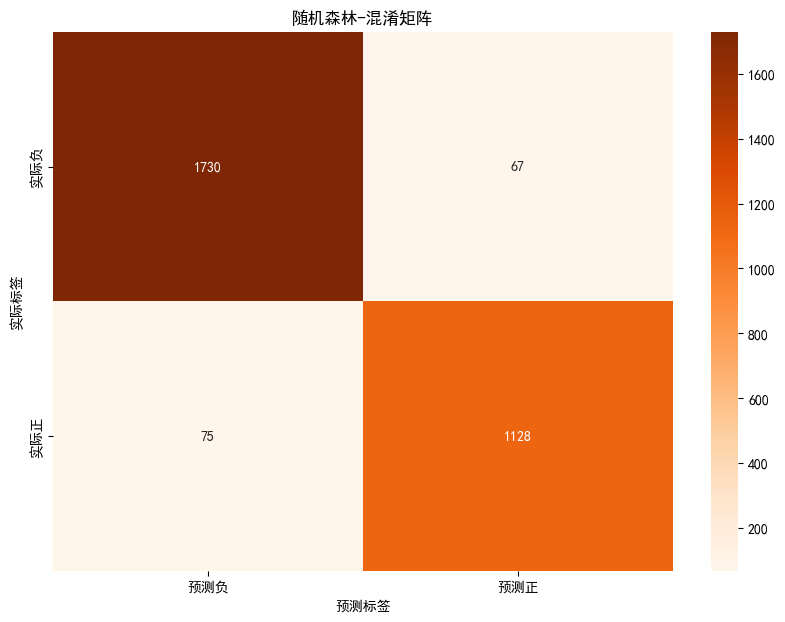

F1 Score: 0.9408


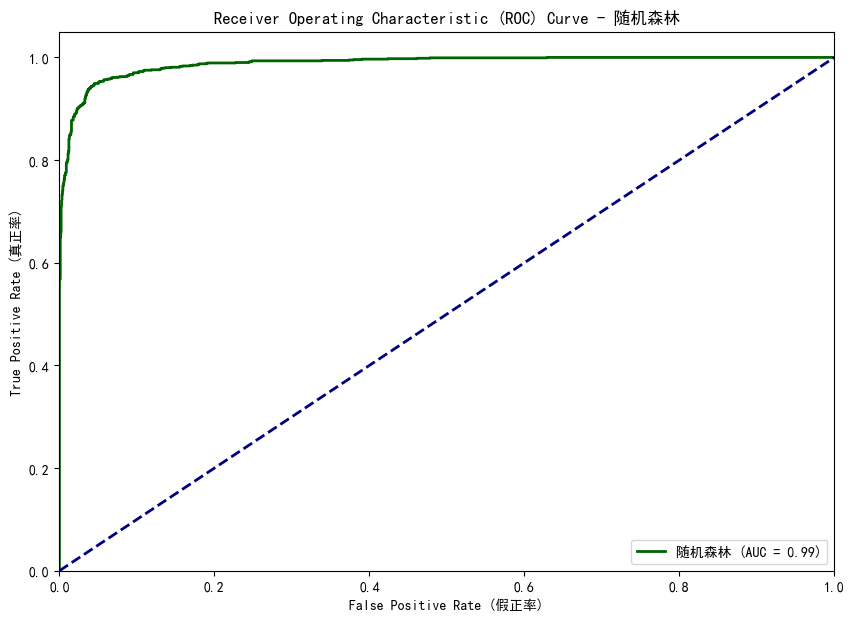

In [9]:
# 导入必要的库
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import time
import seaborn as sns


# 初始化计时
start = time.time()

# 超参数网格
param_grid = {
    'n_estimators': [50, 100, 200],  # 随机森林核心参数：决策树的数量
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],  # 适当缩减范围以提升调参效率
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'bootstrap': [True, False]  # 随机森林特有：是否使用bootstrap抽样
}

# 初始化随机森林模型 
rf = RandomForestClassifier(random_state=42, n_jobs=-1)  

# 网格搜索最优参数
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1,
    refit=True
)
grid_search.fit(X_train, y_train) 

# 输出最优参数
print('最优参数是{}'.format(grid_search.best_params_))

# 获取最优模型
best_rf = grid_search.best_estimator_

# 计算训练耗时
train_end = time.time()
train_time = train_end - start
print('随机森林训练耗时: {:.4f}秒'.format(train_time))

# 计算准确率
train_score = best_rf.score(X_train, y_train)
test_score = best_rf.score(X_test, y_test)

# 预测计时
predict_start = time.time()
y_pred = best_rf.predict(X_test)  # 测试集预测结果（类别）
rf_pred_prob = best_rf.predict_proba(X_test)[:, 1]  # 测试集预测概率（正例）
predict_end = time.time()
predict_time = predict_end - predict_start

# 输出准确率和预测耗时
print('训练集准确率: {:.4f}'.format(train_score))
print('测试集准确率: {:.4f}'.format(test_score))
print('预测花费时间: {:.4f}秒'.format(predict_time))

# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,  # 显示数值
    fmt='d',     # 数值格式为整数
    cmap='Oranges',
    xticklabels=['预测负', '预测正'],
    yticklabels=['实际负', '实际正']
)
plt.xlabel('预测标签')
plt.ylabel('实际标签')
plt.title('随机森林-混淆矩阵')
plt.show()

# 输出F1分数
print('F1 Score: {:.4f}'.format(f1_score(y_test, y_pred)))

# 绘制ROC曲线
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_prob)  # 计算假正率/真正率
roc_auc_rf = auc(fpr_rf, tpr_rf)                      # 计算AUC值

plt.figure(figsize=(10, 7))
plt.plot(
    fpr_rf, tpr_rf,
    color='darkgreen',
    lw=2,
    label='随机森林 (AUC = %0.2f)' % roc_auc_rf
)
# 绘制随机猜测基准线（对角线）
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# 坐标轴范围
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# 坐标轴标签和标题
plt.xlabel('False Positive Rate (假正率)')
plt.ylabel('True Positive Rate (真正率)')
plt.title('Receiver Operating Characteristic (ROC) Curve - 随机森林')  
plt.legend(loc="lower right")  # 图例位置
plt.show()

In [22]:
#抽取50条进行检验
import random

y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


test_total = len(X_test)
sample_num = 50  # 抽取样本数
# 限制start范围：0 ≤ start ≤ 测试集长度-50，若测试集不足50条，直接取全部
if test_total < sample_num:
    start = 0
    sample_num = test_total
    print(f"测试集仅{test_total}条数据，不足50条，将抽取全部数据测试")
else:
    start = random.randint(0, test_total - sample_num)  # 修正原100-2400的硬编码，适配任意测试集长度

# 抽取50条数据（特征+标签），因已重置索引，切片后样本完全匹配
X_data = X_test[start:start+sample_num]
y_data = y_test[start:start+sample_num]
success_test = 0


for sequence_index in range(len(X_data)):
 
    comment_words = all_words[start + sequence_index]
    # 拼接分词结果输出（处理空评论情况）
    comment_str = '/'.join(comment_words) if comment_words else '【空评论】'
    print(f"评论分词结果：{comment_str}")
    # 模型预测（传入二维数组，适配sklearn要求）
    x_sample = X_data[sequence_index:sequence_index+1]  
    res = best_rf.predict(x_sample)[0]  # 取预测结果的标量值（0/1）

    # 输出预测结果
    if res == 0:             
        print('Predict result : 好评', end='\t')             
    else:              
        print('Predict result : 差评', end='\t')            
    # 输出实际结果（y_data已重置索引，直接用位置索引访问，数值类型）
    y_actual = y_data.iloc[sequence_index]  # 用iloc确保位置访问，兼容Series
    if y_actual == 0:
        print('Actual results: 好评', end='\t')
    else:   
        print('Actual results: 差评', end='\t')
    # 判断预测是否正确
    if res == y_actual:
        print('Predict success!', end='\t')
        success_test += 1
    else:
        print('Predict fail!', end='\t')
    print('\n' + '-'*80 + '\n')  
# 计算并输出预测准确度
accuracy = success_test / sample_num
print(f'本次随机森林测试共抽取{sample_num}条数据，预测准确度为: {accuracy:.4f}（{success_test}/{sample_num}）')

评论分词结果：正品/查询/翻新/机/运行/速度/软件/适配/更/快/屏幕/效果/惊艳/散热/性能/听/不到/风扇/转/外形/外观/APPLE/不用/说
Predict result : 差评	Actual results: 差评	Predict fail!	
--------------------------------------------------------------------------------

评论分词结果：付完/尾款/第二天/到货/M1/max/真/盖/运行/流畅/Photoshop/堆栈/五十张/照片/轻松/应对/外观/漂亮/接口/非常适合/办公/图片
Predict result : 差评	Actual results: 差评	Predict fail!	
--------------------------------------------------------------------------------

评论分词结果：运行/速度/新/处理器/快/顺畅/屏幕/效果/舒服/原彩/显示/散热/性能/凉快/散热/能力/强/倒/资料/装/软件/没测/游戏/外形/外观/好看/简约/平整/轻薄/程度/上班/下班/来来回回/特色/第一次/苹果电脑/很棒/学习
Predict result : 差评	Actual results: 差评	Predict fail!	
--------------------------------------------------------------------------------

评论分词结果：苹果/生产/技术/工艺/真的/太赞/熟悉/开机/声音/干脆/铝合金/打造/金属/机身/科技/感/十足/16/寸/大家伙/重/接受/屏蔽/运行/流畅/很棒/感觉/京东/物流/真的/快/快递/小哥/服务态度/不错
Predict result : 差评	Actual results: 差评	Predict fail!	
--------------------------------------------------------------------------------

评论分词结果：电脑/快递/很快/外边/京东/包装/箱子/破损/里边/苹果/箱子/完好无损/学校/暴力/快递/接受/电脑/满意/

In [26]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
# 解决中文/负号显示问题（关键，避免图表乱码）
plt.rcParams['font.sans-serif'] = [ 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
# 设置全局绘图样式（优化颜值，统一风格）
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'f8f9fa'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.4
import mplfinance as mpf
import warnings 
warnings.filterwarnings('ignore')

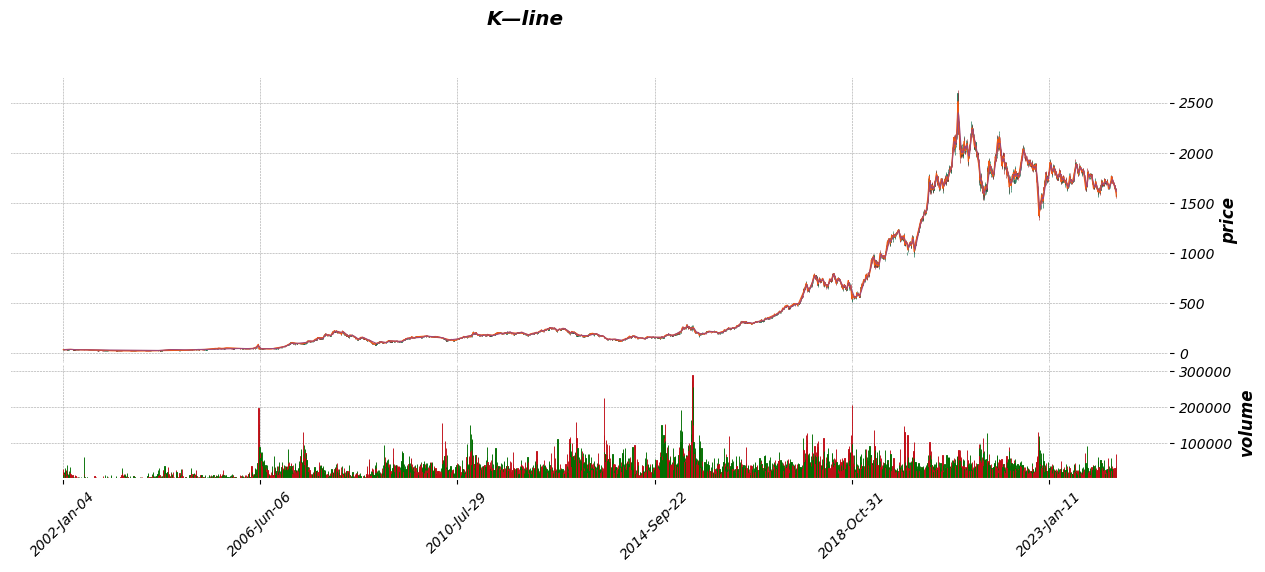

In [24]:
df=pd.read_excel(r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\MaoTai.xlsx')
df.rename(columns={
    'trade_date':'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'vol': 'Volume'  
}, inplace=True)
#转换日期格式
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.sort_index(ascending=True,inplace=True)
#绘制蜡烛图
mpf.plot(df, type='candle', style='charles',
         title='K—line',
         ylabel='price',
         ylabel_lower='volume',
         volume=True,
         figratio=(14,5),
         mav=(3,6,9),
         warn_too_much_data=1000
         
         )  
plt.show()

In [27]:
df['Return'] = df['Close'].pct_change()
df['MA5'] = df['Close'].rolling(5).mean()
df['MA10'] = df['Close'].rolling(10).mean()

window = 14
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.ewm(alpha=1/window, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/window, adjust=False).mean()

rs = avg_gain / avg_loss
df['RSI'] = 100 - (100/(1+rs))

feature_cols = ['Open','High','Low','Volume','Return','MA5','MA10','RSI']

# 防止未来函数
df[feature_cols] = df[feature_cols].shift(1)

In [28]:
import time
from sklearn.ensemble import RandomForestRegressor  # 随机森林回归器
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# 目标变量：预测未来5天的收盘价
df['target'] = df['Close'].shift(-5)
df = df.dropna()

X = df[feature_cols]
y = df['target']


In [30]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, None],
    "min_samples_split": [2, 5],
}

base_model = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

grid = GridSearchCV(
    base_model,
    param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)

print("\nBest Params:", grid.best_params_)

model = grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [31]:
train_size = int(len(X) * 0.8)

preds = []
real = []
dates = []

for i in range(train_size, len(X)):
    X_train = X.iloc[:i]
    y_train = y.iloc[:i]

    X_test = X.iloc[i:i+1]
    y_test = y.iloc[i:i+1]

    model.fit(X_train, y_train)

    pred = model.predict(X_test)[0]

    preds.append(pred)
    real.append(y_test.values[0])
    dates.append(X_test.index[0])


In [32]:
rmse = np.sqrt(mean_squared_error(real, preds))
print("\nRolling RMSE:", rmse)

result_df = pd.DataFrame({
    "Date": dates,
    "Real_Close": real,
    "Pred_Close": preds
}).set_index("Date")

print(result_df.tail())



Rolling RMSE: 71.1024952265111
            Real_Close  Pred_Close
Date                              
2024-05-30     1639.81   1701.2864
2024-05-31     1619.18   1689.3890
2024-06-03     1569.00   1701.6981
2024-06-04     1571.68   1693.1525
2024-06-05     1555.01   1699.4644



未来5天收盘价预测对比：
            Real_Close  Pred_Close      绝对误差
Date                                        
2024-05-30     1639.81   1701.2864   61.4764
2024-05-31     1619.18   1689.3890   70.2090
2024-06-03     1569.00   1701.6981  132.6981
2024-06-04     1571.68   1693.1525  121.4725
2024-06-05     1555.01   1699.4644  144.4544


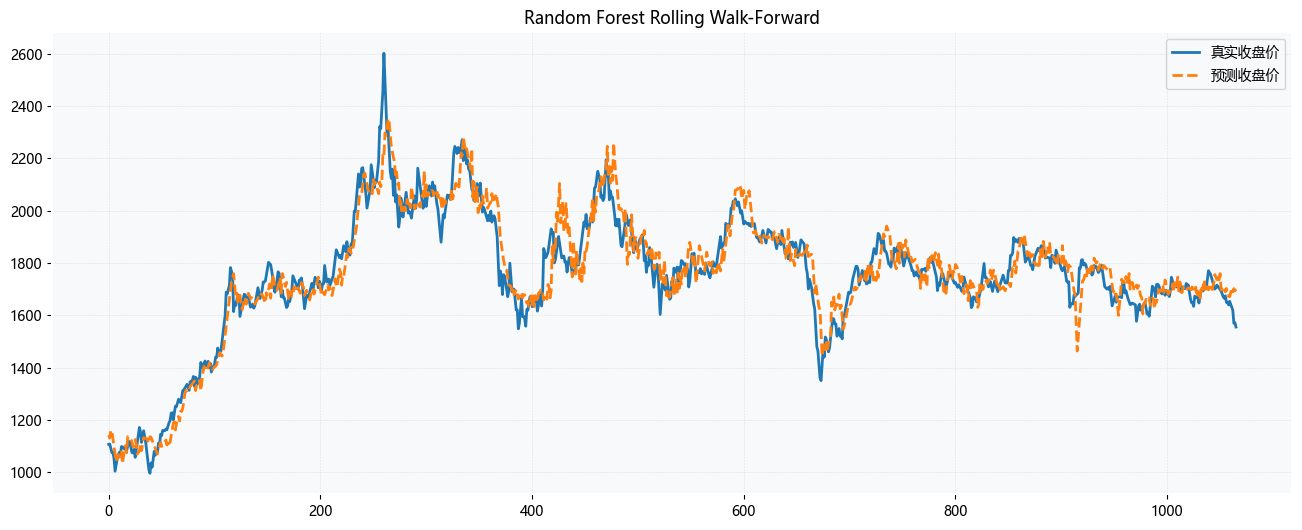

In [35]:
future_compare = result_df.tail(5).copy()
future_compare['绝对误差'] = np.abs(
    future_compare['Real_Close'] - future_compare['Pred_Close']
)

print("\n未来5天收盘价预测对比：")
print(future_compare)

result_df = pd.DataFrame({
    'True': real,
    'Pred': preds
}).reset_index()

plt.figure(figsize=(16,6))
plt.plot(result_df.index, result_df['True'], label='真实收盘价')
plt.plot(result_df.index, result_df['Pred'], linestyle='--', label='预测收盘价')
plt.legend()
plt.title('Random Forest Rolling Walk-Forward')
plt.grid(alpha=0.3)
plt.show()

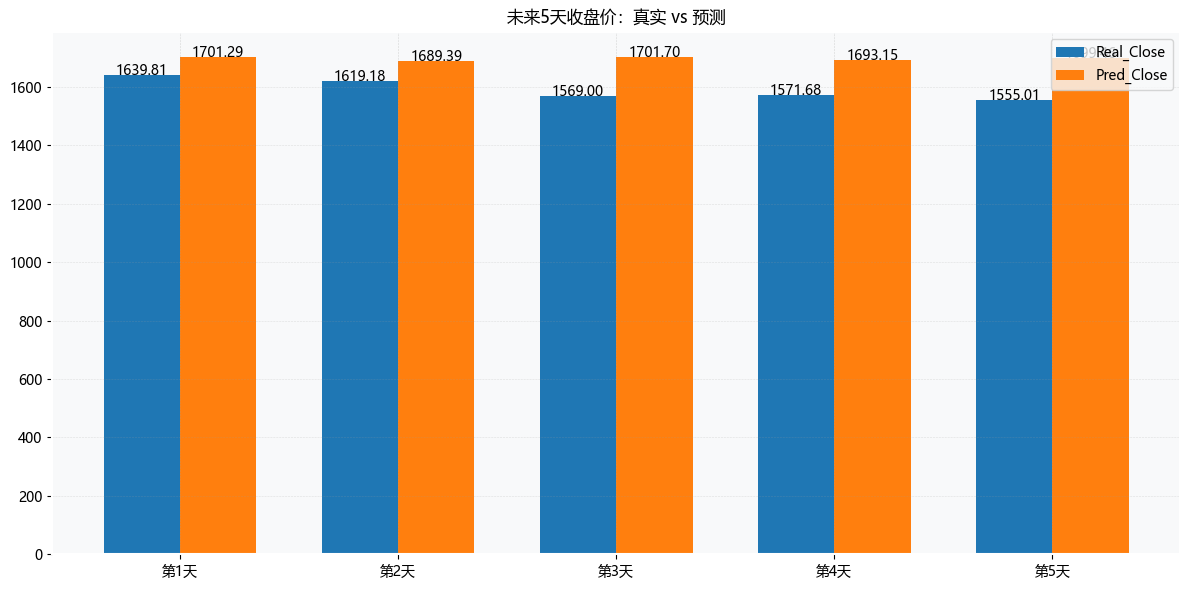

In [37]:
fig, ax = plt.subplots(figsize=(12,6))

x_future = np.arange(1,6)
bar_width = 0.35

true_vals = future_compare['Real_Close'].values
pred_vals = future_compare['Pred_Close'].values

ax.bar(x_future-bar_width/2, true_vals, bar_width, label='Real_Close')
ax.bar(x_future+bar_width/2, pred_vals, bar_width, label='Pred_Close')

for i,(t,p) in enumerate(zip(true_vals,pred_vals)):
    ax.text(x_future[i]-bar_width/2, t, f'{t:.2f}', ha='center')
    ax.text(x_future[i]+bar_width/2, p, f'{p:.2f}', ha='center')

ax.set_title('未来5天收盘价：真实 vs 预测')
ax.set_xticks(x_future)
ax.set_xticklabels([f'第{i}天' for i in x_future])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#### 4.特征重要性  
- 随机森林可以使测量每个特征的相对重要性变得容易
- 模型训练后可以为每个特征计算重要性
- 重要性即为该特征的树节点平均减少杂志的程度

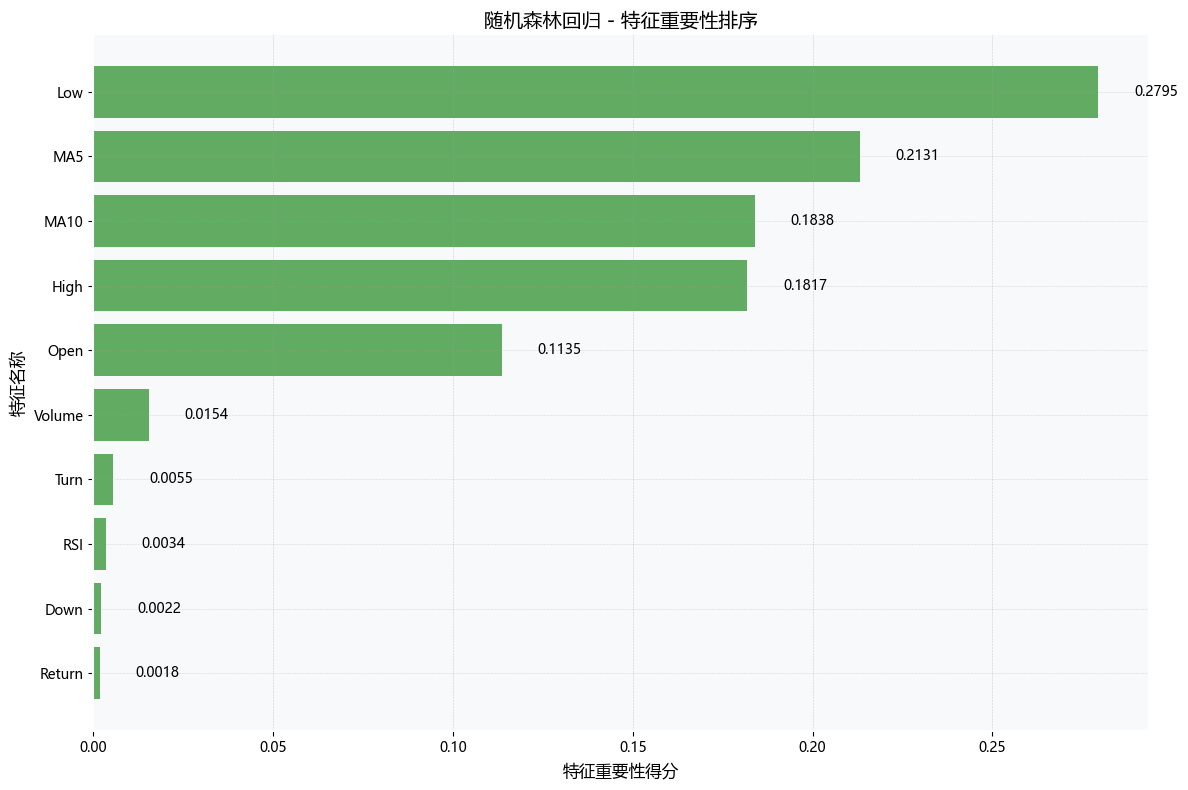

In [38]:
feature_importance = best_rf.feature_importances_  # 随机森林内置的特征重要性（基于节点不纯度）
feature_names = ['Open', 'High', 'Low', 'Down','Volume', 'Turn','MA5', 'MA10', 'RSI', 'Return'] 
importance_df = pd.DataFrame({
    '特征名': feature_names,
    '重要性': feature_importance
}).sort_values(by='重要性', ascending=False)
plt.figure(figsize=(12, 8))
# 绘制水平柱状图
bars = plt.barh(
    importance_df['特征名'][::-1],  # 逆序，让最重要的特征在顶部
    importance_df['重要性'][::-1],
    color='forestgreen',
    alpha=0.7
)

# 添加数值标签
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.01,  # 标签位置（右侧）
        bar.get_y() + bar.get_height()/2,  # 垂直居中
        f'{width:.4f}',  # 保留4位小数
        ha='left',  # 水平对齐
        va='center'  # 垂直对齐
    )

# 设置图表样式
plt.xlabel('特征重要性得分', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.title('随机森林回归 - 特征重要性排序', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()  # 自适应布局，避免标签被截断
plt.show()

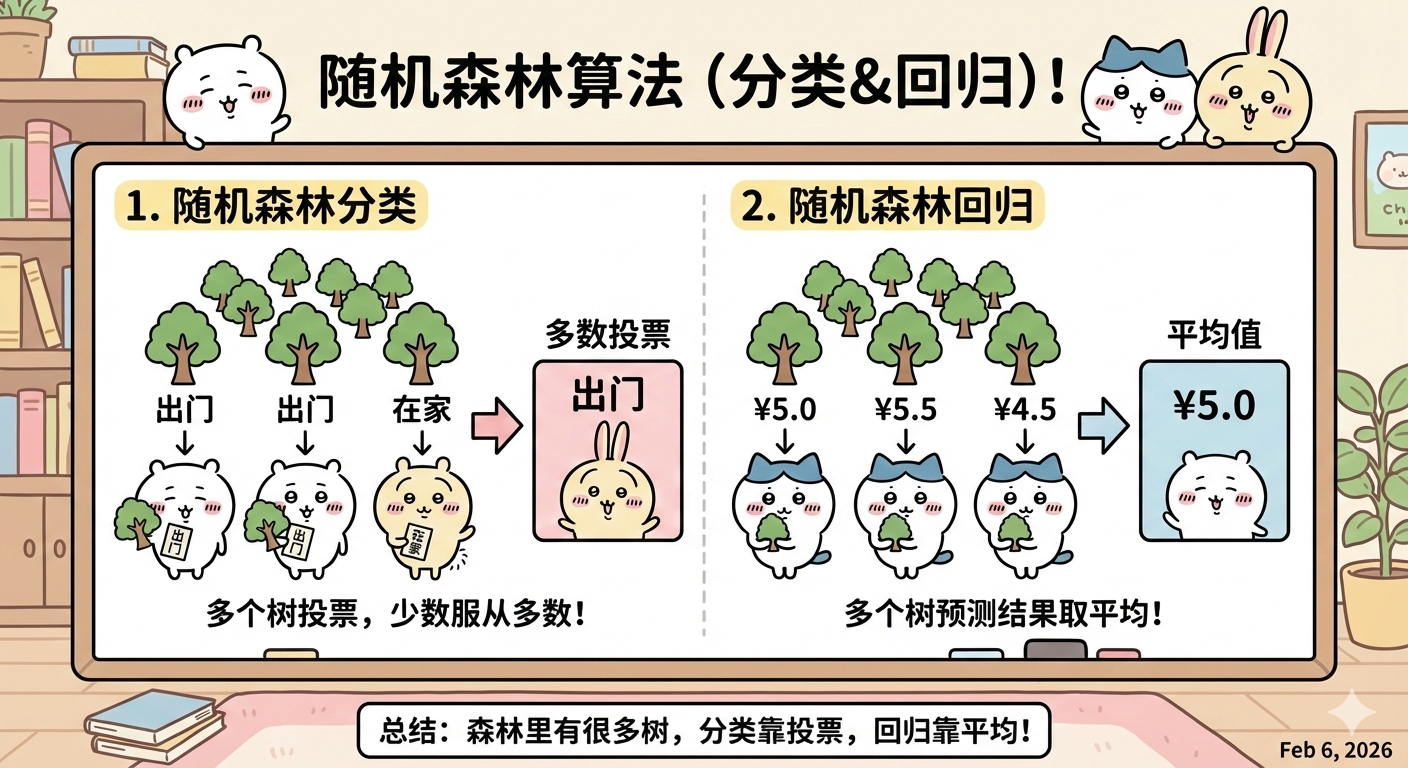